#  Task 2: Sentiment and Thematic Analysis

In [1]:
# import necessary libraries
import pandas as pd
from transformers import pipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [2]:
# Load the Cleaned Data
df = pd.read_csv('../data/bank_reviews_clean.csv')

print(f"Total Reviews Loaded: {df.shape[0]}")
df.head()

Total Reviews Loaded: 773


,review_text,rating,date,bank_name,source,clean_review
0,A great app. It's like carrying a bank in your...,4,2025-06-07,Commercial Bank of Ethiopia,Google Play,a great app its like carrying a bank in your p...
1,More than garrantty bank EBC.,4,2025-06-07,Commercial Bank of Ethiopia,Google Play,more than garrantty bank ebc
2,really am happy to this app it is Siple to use...,5,2025-06-07,Commercial Bank of Ethiopia,Google Play,really am happy to this app it is siple to use...
3,I liked this app. But the User interface is ve...,2,2025-06-07,Commercial Bank of Ethiopia,Google Play,i liked this app but the user interface is ver...
4,"""Why don’t your ATMs support account-to-accoun...",4,2025-06-06,Commercial Bank of Ethiopia,Google Play,why don’t your atms support accounttoaccount t...


# Initialize Sentiment Analysis Model (DistilBERT)

In [4]:
# Load pretrained sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

Device set to use cpu


In [5]:
# Define Sentiment Scoring Function

def get_bert_sentiment(text):
    """
    Returns the sentiment label and score from DistilBERT model.
    """
    try:
        result = classifier(text[:512])[0]  # Limit to 512 tokens for BERT
        return pd.Series([result['label'], result['score']])
    except Exception as e:
        return pd.Series(['ERROR', 0.0])

# Apply to clean_review column
df[['bert_sentiment', 'bert_score']] = df['clean_review'].apply(get_bert_sentiment)

# Remove rows where sentiment analysis failed
df = df[df['bert_sentiment'] != 'ERROR']

In [6]:
# Sentiment Label Mapping to numeric values
def sentiment_to_numeric(label):
    if label == 'POSITIVE':
        return 1
    else:
        return 0

df['sentiment_numeric'] = df['bert_sentiment'].apply(sentiment_to_numeric)

In [7]:
# Aggregating Sentiment by Bank and Rating

agg_df = df.groupby(['bank_name', 'rating'])['sentiment_numeric'].mean().reset_index()
agg_df.rename(columns={'sentiment_numeric': 'mean_positive_score'}, inplace=True)

# Preview
agg_df.head()

,bank_name,rating,mean_positive_score
0,Bank of Abyssinia,1,0.063584
1,Bank of Abyssinia,2,0.000000
2,Bank of Abyssinia,3,0.200000
3,Bank of Abyssinia,4,0.166667
4,Bank of Abyssinia,5,0.653846


## save outputs

In [8]:
# Save individual sentiment predictions
df.to_csv('../data/bank_reviews_bert_sentiment.csv', index=False)

In [9]:
# Save aggregated sentiment scores
agg_df.to_csv('../data/bank_sentiment_aggregated.csv', index=False)

print(" Sentiment predictions and aggregation saved successfully.")

 Sentiment predictions and aggregation saved successfully.


# Visualization

C:\Users\jilow\AppData\Local\Temp\ipykernel_58972\2060813533.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='bert_sentiment', palette='Set2', order=['POSITIVE', 'NEGATIVE'])


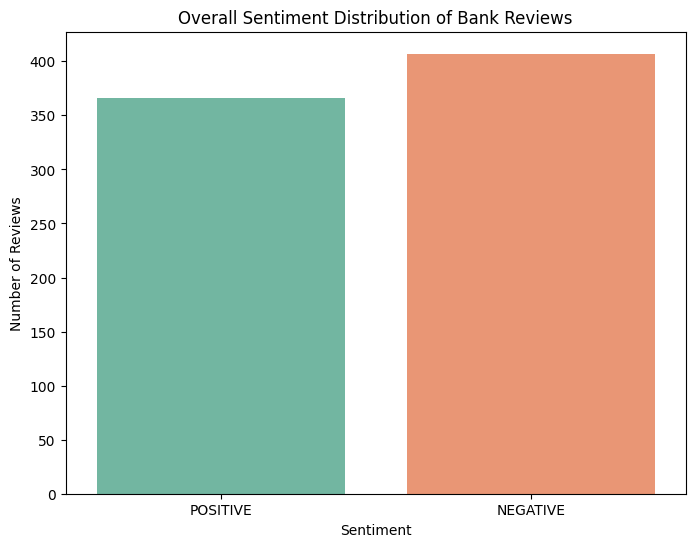

In [10]:
# Bar plot of overall sentiment distribution
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='bert_sentiment', palette='Set2', order=['POSITIVE', 'NEGATIVE'])
plt.title('Overall Sentiment Distribution of Bank Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

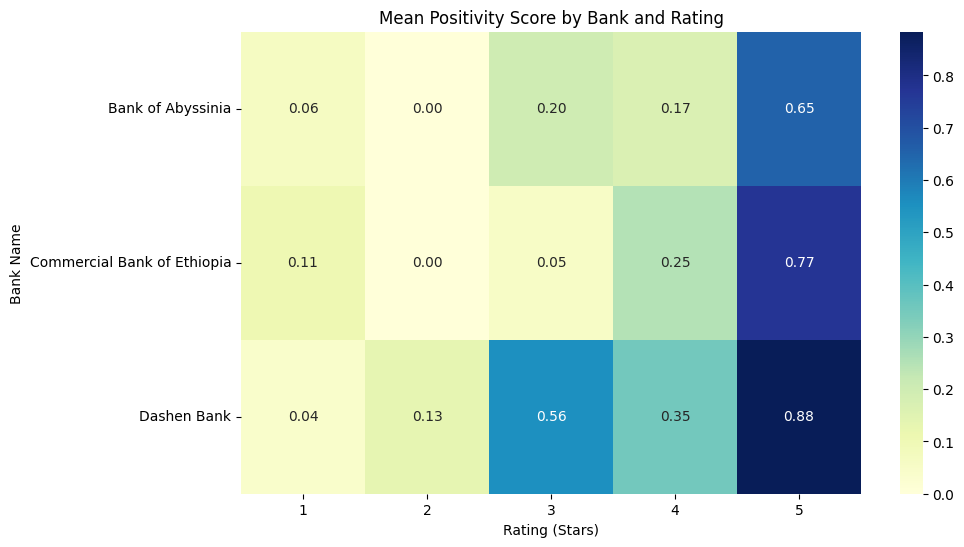

In [11]:
# Heatmap: Mean positivity score by Bank and Rating
pivot_table = agg_df.pivot(index='bank_name', columns='rating', values='mean_positive_score')

plt.figure(figsize=(10,6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Mean Positivity Score by Bank and Rating')
plt.xlabel('Rating (Stars)')
plt.ylabel('Bank Name')
plt.show()


In [12]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='Set2',
        max_words=200
    ).generate(' '.join(text))
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()


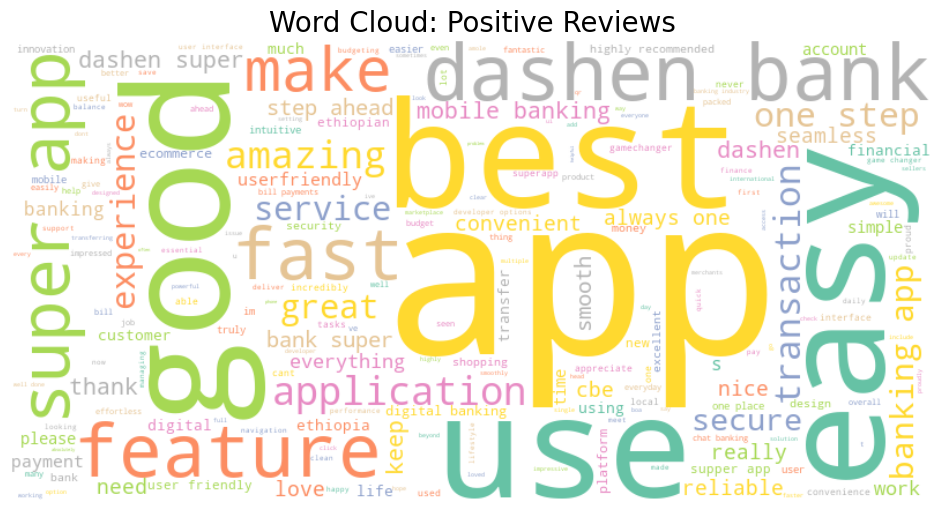

In [13]:
# Word Cloud for Positive Reviews
positive_reviews = df[df['bert_sentiment'] == 'POSITIVE']['clean_review']
generate_wordcloud(positive_reviews, 'Word Cloud: Positive Reviews')

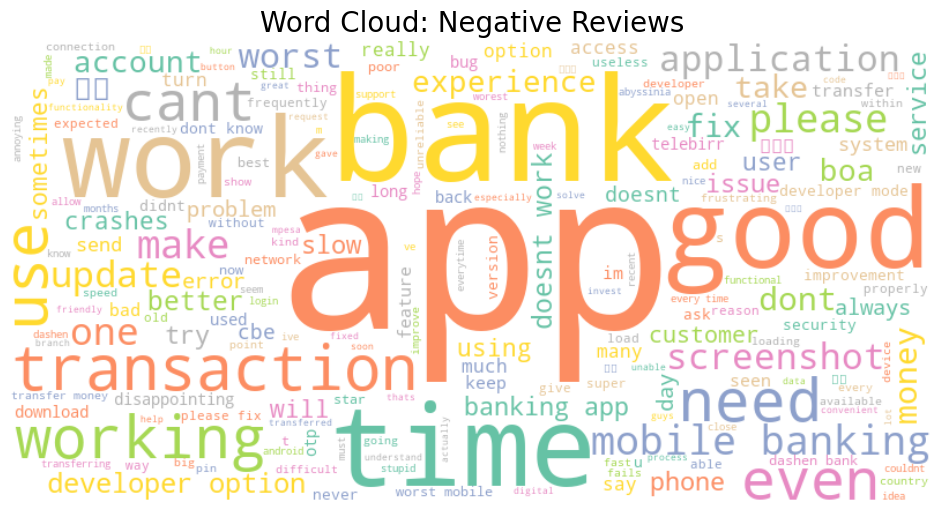

In [14]:
# Word Cloud for Negative Reviews
negative_reviews = df[df['bert_sentiment'] == 'NEGATIVE']['clean_review']
generate_wordcloud(negative_reviews, 'Word Cloud: Negative Reviews')